# Fastai based Mixed Input Model
My Idea here was to use the approach that succeded in the Rossman Kaggle challenge [see the fastai notebook here](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb)
The data loading and initial feature engineering I borrowed heavily from [YouHan Lees Kernel](https://www.kaggle.com/youhanlee/hello-elo-ensemble-will-help-you) and [Hyun woo kim](https://www.kaggle.com/chocozzz/simple-data-exploration-with-python-lb-3-764/notebook)
I think in this challenge the key thing is the feature engineering.
Here I start with the model and use the borrowed feature engineering as a starting point.
I might use these embedding layers to do the feature engineering on the new and historic transactions but as of Yet I'm not sure how to do it.
Suggestions are always welcome


https://www.kaggle.com/guntherthepenguin/fastai-based-mixed-input-model-lb-3-8

https://www.kaggle.com/c/elo-merchant-category-recommendation/

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai import *
from fastai.tabular import *


In [2]:
path='~/my_data/elo/'

In [3]:
!ls {path}

Data_Dictionary.xlsx	     new_merchant_transactions.csv  test.csv
elo_val_idx_02.csv	     sample_submission.csv	    train.csv
historical_transactions.csv  submission-2018-12-22.csv
merchants.csv		     submission-elo-2018-12-29.csv


In [4]:
new_transactions = pd.read_csv(f'{path}new_merchant_transactions.csv')
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [5]:
new_transactions['authorized_flag'] = new_transactions['authorized_flag']=='Y'

In [6]:
def aggregate_new_transactions(new_trans):    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

add_datepart(new_transactions,'purchase_date')
new_trans = aggregate_new_transactions(new_transactions)
new_trans.head()

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_merchant_id_nunique,new_city_id_nunique,new_purchase_amount_sum,new_purchase_amount_median,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_median,new_installments_max,new_installments_min,new_installments_std,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2.0,True,2,2,-1.328524,-0.664262,-0.656749,-0.671775,0.010625,2,1.0,1,1,0.000000,2,2
1,C_ID_0001238066,26,26.0,True,25,8,-14.850055,-0.649235,-0.078318,-0.740897,0.173436,42,1.0,10,-1,2.079941,1,2
2,C_ID_0001506ef0,2,2.0,True,1,1,-1.447354,-0.723677,-0.715352,-0.732001,0.011773,0,0.0,0,0,0.000000,1,1
3,C_ID_0001793786,31,31.0,True,31,7,-0.229620,-0.372748,3.129932,-0.737892,0.947223,0,0.0,0,0,0.000000,1,2
4,C_ID_000183fdda,11,11.0,True,11,2,-6.590778,-0.665765,-0.107680,-0.732332,0.182877,16,1.0,4,-1,1.293340,1,2


In [7]:
del new_transactions

In [8]:
historical_transactions = pd.read_csv(f'{path}historical_transactions.csv')
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [9]:
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag']=='Y'

In [10]:
def aggregate_historical_transactions(history):
    
#     history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
#                                       astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
#         'purchase_date': [np.ptp],
        'month_lag': ['median', 'max', 'min', 'std']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

add_datepart(historical_transactions,'purchase_date')
history = aggregate_historical_transactions(historical_transactions)
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_merchant_id_nunique,hist_city_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_median,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_median,hist_installments_max,hist_installments_min,hist_installments_std,hist_month_lag_median,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std
0,C_ID_00007093c1,149,114.0,0.765101,29,4,-76.845041,-0.587627,1.507069,-0.728876,0.298141,192,1.0,6,1,0.764900,-6.0,0,-12,3.453114
1,C_ID_0001238066,123,120.0,0.975610,65,18,-72.447201,-0.648184,0.768095,-0.734887,0.190235,198,1.0,10,-1,1.485637,-2.0,0,-5,1.288980
2,C_ID_0001506ef0,66,62.0,0.939394,28,3,-34.601879,-0.703707,1.493545,-0.740491,0.472284,1,0.0,1,0,0.123091,-3.0,0,-13,4.237500
3,C_ID_0001793786,216,189.0,0.875000,119,10,-36.786013,-0.487911,4.554145,-0.745405,0.836046,5,0.0,1,0,0.150723,-3.0,0,-9,2.306373
4,C_ID_000183fdda,144,137.0,0.951389,73,9,-68.837938,-0.661294,2.764788,-0.737892,0.524948,264,1.0,10,-1,2.118846,-2.0,0,-6,1.895264


In [11]:
del historical_transactions

In [12]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    add_datepart(df,'first_active_month')
    return df
train = read_data(f'{path}/train.csv')
test = read_data(f'{path}/test.csv')

target='target'


In [13]:
# # One-hot encode features
# ohe_df_1 = pd.get_dummies(train['feature_1'], prefix='f1_')
# ohe_df_2 = pd.get_dummies(train['feature_2'], prefix='f2_')
# ohe_df_3 = pd.get_dummies(train['feature_3'], prefix='f3_')

# ohe_df_4 = pd.get_dummies(test['feature_1'], prefix='f1_')
# ohe_df_5 = pd.get_dummies(test['feature_2'], prefix='f2_')
# ohe_df_6 = pd.get_dummies(test['feature_3'], prefix='f3_')

# # Numerical representation of the first active month
# train_df = pd.concat([train, ohe_df_1, ohe_df_2, ohe_df_3], axis=1, sort=False)
# test_df = pd.concat([test, ohe_df_4, ohe_df_5, ohe_df_6], axis=1, sort=False)
# del ohe_df_1, ohe_df_2, ohe_df_3
# del ohe_df_4, ohe_df_5, ohe_df_6
# gc.collect()

In [14]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new_trans, on='card_id', how='left')
test = pd.merge(test, new_trans, on='card_id', how='left')

In [15]:
train=train.set_index('card_id')
test=test.set_index('card_id')

In [16]:
train.head().T

card_id,C_ID_92a2005557,C_ID_3d0044924f,C_ID_d639edf6cd,C_ID_186d6a6901,C_ID_cdbd2c0db2
feature_1,5,4,2,4,1
feature_2,2,1,2,3,3
feature_3,1,0,0,0,0
target,-0.820283,0.392913,0.688056,0.142495,-0.159749
first_active_monthYear,2017,2017,2016,2017,2017
first_active_monthMonth,6,1,8,9,11
first_active_monthWeek,22,52,31,35,44
first_active_monthDay,1,1,1,1,1
first_active_monthDayofweek,3,6,0,4,2
first_active_monthDayofyear,152,1,214,244,305


In [17]:
test.head().T

card_id,C_ID_0ab67a22ab,C_ID_130fd0cbdd,C_ID_b709037bc5,C_ID_d27d835a9f,C_ID_2b5e3df5c2
feature_1,3,2,5,2,5
feature_2,3,3,1,1,1
feature_3,1,0,1,0,1
first_active_monthYear,2017,2017,2017,2017,2015
first_active_monthMonth,4,1,8,12,12
first_active_monthWeek,13,52,31,48,49
first_active_monthDay,1,1,1,1,1
first_active_monthDayofweek,5,6,1,4,1
first_active_monthDayofyear,91,1,213,335,335
first_active_monthIs_month_end,False,False,False,False,False


In [18]:
cat_vars = [col  for col in train.columns if('feature' in col or 'first_active_month' in col)]
contin_vars = [col  for col in train.columns if ('feature' not in col and 'first_active_month' not in col) and target not in col]

In [19]:
train = train[cat_vars+contin_vars+[target]].copy()
n = len(train); n

201917

In [20]:
test[target] = 0
test = test[cat_vars+contin_vars+[target]].copy()

In [21]:
with open('/home/jupyter/my_data/elo/elo_val_idx_02.csv') as f:
    val_idx = f.readlines()
val_idx = [int(v) for v in val_idx]

In [22]:
procs = [FillMissing, Categorify, Normalize]

try:
    del data
    del learn
    gc.collect()
except Exception:
    pass

data = (TabularList.from_df(train, path=path, cat_names=cat_vars, 
                            cont_names=contin_vars, procs=procs,)
#     .random_split_by_pct()
    .split_by_idx(val_idx)
    .label_from_df(cols=target, label_cls=FloatList,log=False)
    .add_test(ItemList.from_df(test,path))
    .databunch())

In [23]:
max_y = (np.max(train[target])*1.2)
min_y = (np.min(train[target])*1.2)
y_range = torch.tensor([min_y, max_y], device=defaults.device)
print(y_range,min_y, max_y)

def rmse(pred, targ):
    "RMSE between `pred` and `targ`."
    assert pred.numel() == targ.numel(), "Expected same numbers of elements in pred & targ"
    if len(pred.shape)==2: 
        pred=pred.squeeze(1)
    var = np.square(targ - pred)
    return torch.sqrt(var.mean())

tensor([-39.8631,  21.5581], device='cuda:0') -39.86313714 21.55808208


In [24]:
learn = tabular_learner(data, layers=[1000, 500], ps=[0.001,0.01], emb_drop=0.04, 
#                         model_dir='..', 
                        y_range=y_range, metrics=rmse)


In [25]:
l = learn.model

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


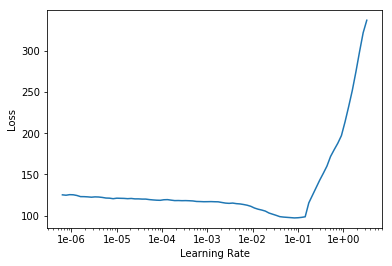

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1, 3e-3,)

epoch,train_loss,valid_loss,rmse
1,14.290254,13.853839,3.215731


In [29]:
learn.save('1')

In [30]:
temp = learn.load('1')
# learn.fit_one_cycle(1, 3e-2,)

In [31]:
learn.fit(5, 3e-3,)

epoch,train_loss,valid_loss,rmse
1,14.240781,15.113987,3.431534
2,14.421887,17.232019,3.615712
3,12.617868,18.557386,3.733317
4,13.189789,17.229815,3.597510
5,12.794602,15.955573,3.447398


In [32]:
learn.save('2')

In [33]:
learn.fit_one_cycle(5, 3e-3,wd=.2)

epoch,train_loss,valid_loss,rmse
1,13.764488,16.018436,3.465874
2,14.877350,14.757179,3.317771
3,15.940503,14.219027,3.236105
4,13.007158,14.371345,3.268515
5,12.567204,14.003665,3.244750


## More training is resulting in reduction of training loss. This means we are now overfitting.
### Over rmse score (3.350513) doesn't match with kaggle rmse score ( 3.955) it means our validation set is not correct. 

In [34]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [35]:
from datetime import datetime
ids = test.index.values
vals = preds.numpy()
sub = pd.DataFrame({'card_id': ids, 'target': vals[:,0]})

fn = "submission-elo-%s.csv"%datetime.now().date()
sub.to_csv(f'{path}{fn}', index = False, header = True)
sub.head()


,card_id,target
0,C_ID_0ab67a22ab,-2.523678
1,C_ID_130fd0cbdd,-0.539436
2,C_ID_b709037bc5,-1.011539
3,C_ID_d27d835a9f,-0.233452
4,C_ID_2b5e3df5c2,-2.789841


In [36]:
np.max(sub), np.min(sub)

(card_id    C_ID_ffff756266
 target             21.5581
 dtype: object, card_id    C_ID_0001238066
 target            -39.8631
 dtype: object)

In [37]:
# sub.target.plot(kind='bar')

In [38]:
from IPython.display import FileLink, FileLinks
FileLinks('/home/jupyter/my_data/elo/')

/home/jupyter/my_data/elo/
  historical_transactions.csv
  submission-elo-2018-12-29.csv
  Data_Dictionary.xlsx
  test.csv
  new_merchant_transactions.csv
  elo_val_idx_02.csv
  sample_submission.csv
  merchants.csv
  submission-2018-12-22.csv
  train.csv